We want to implement a model that processes the input image, identifies one track in it, and indicates which pixels correspond to that track.  We will start with the model architecture we're using to regress on track parameters, and modify it to produce lists of pixels.

Author: Dustin Anderson

In [1]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

num_tracks = 6
max_tracks = 10
min_tracks = 1

The training target will now be a list of pixels that correspond to a single track in the image.  To ensure that the model knows which track to look at, we'll also give it a "hint" in the form of the track intercept value.  The intercept acts as a proxy for a track seed, which in practice could be provided by a neural net like the CNN we trained earlier.

First let's make sure the basic concept can be implemented sensibly.  We will train on single-track events and ask the model to find the pixels that are "on". No track seed for now.

In [3]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits >= 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    gen = gen_tracks_intercepts(batch_size, det_shape)
    for tracks, targets, intercepts in gen: # Note: loops forever
        yield tracks, targets
        
def gen_tracks_intercepts(batch_size=batch_size, det_shape=det_shape):
    """Yields tuples of the form (events, targets, intercepts)"""
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = [ np.zeros((batch_size, det_depth)),
                    np.zeros((batch_size, det_width)) ]
        for i, (b, m) in enumerate(zip(bs,ms)):
            tracks[i,0] = simulate_straight_track(m, b, det_shape)
            pixel_x, pixel_y = np.where(tracks[i,0])
            targets[0][i] = pixel_x
            targets[1][i] = pixel_y
        targets[0] = np.expand_dims(targets[0], -1) #needed for compatibility with sparse_categorical_crossentropy loss
        targets[1] = np.expand_dims(targets[1], -1)
        yield tracks, targets, bs
        
# Generator for multi-track events
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, min_tracks=min_tracks, max_tracks=max_tracks):
    gen_single = gen_tracks_intercepts(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_intercepts = np.zeros((batch_size))
        batch_targets = [ np.zeros((batch_size, det_depth, 1)),
                    np.zeros((batch_size, det_width, 1)) ]
        for n in range(batch_size):
            tracks,targets,intercepts = gen_single.next()
            if max_tracks != min_tracks:
                num_tracks = np.random.randint(min_tracks, max_tracks+1)
            else:
                num_tracks = max_tracks
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            batch_intercepts[n] = intercepts[0]
            event_targets = [targets[0][0], targets[1][0]] # first track is the target
            batch_targets[0][n] = event_targets[0]
            batch_targets[1][n] = event_targets[1]
        yield [batch_events, batch_intercepts], batch_targets

def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, num_tracks=num_tracks):
    gen_multi = gen_multi_tracks(batch_size, det_shape, num_tracks, num_tracks)
    while True:
        yield gen_multi.next()

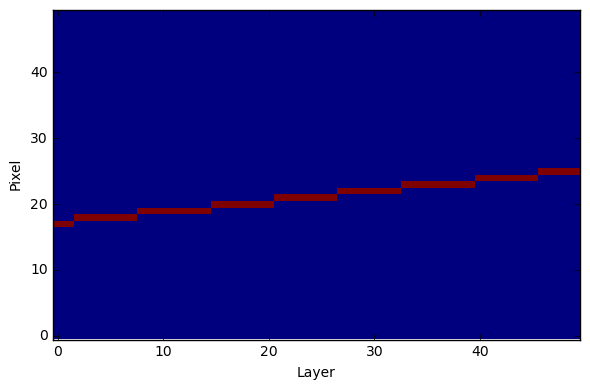

In [351]:
# Test the data generator
tracks, targets = gen_tracks().next()
draw_event(tracks[0,0])

In [352]:
# Model
def build_model_1():
    """Recycle same convolutional architecture used in previous 'houghlike' experiments"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(det_depth)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    # Output a softmax over all pixels in the x- and y-directions
    output_layer_x = layers.TimeDistributed(layers.Dense(det_depth, activation='softmax'))(layer)
    output_layer_y = layers.TimeDistributed(layers.Dense(det_width, activation='softmax'))(layer)
    model = models.Model(input=input_layer, output=[output_layer_x, output_layer_y])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', sample_weight_mode='temporal')
    return model

In [209]:
# Train the model
model_1 = build_model_1()
train_generator = gen_tracks()
%time model_1.fit_generator(train_generator, epoch_size, 3)

Epoch 1/3
256000/256000 [==============================] - 224s - loss: 1.2938 - timedistributed_19_loss: 0.6640 - timedistributed_20_loss: 0.6297   
Epoch 2/3
256000/256000 [==============================] - 224s - loss: 0.3748 - timedistributed_19_loss: 0.1460 - timedistributed_20_loss: 0.2288   
Epoch 3/3
256000/256000 [==============================] - 224s - loss: 0.2424 - timedistributed_19_loss: 0.0808 - timedistributed_20_loss: 0.1616   
CPU times: user 5min 57s, sys: 6min 42s, total: 12min 39s
Wall time: 11min 21s


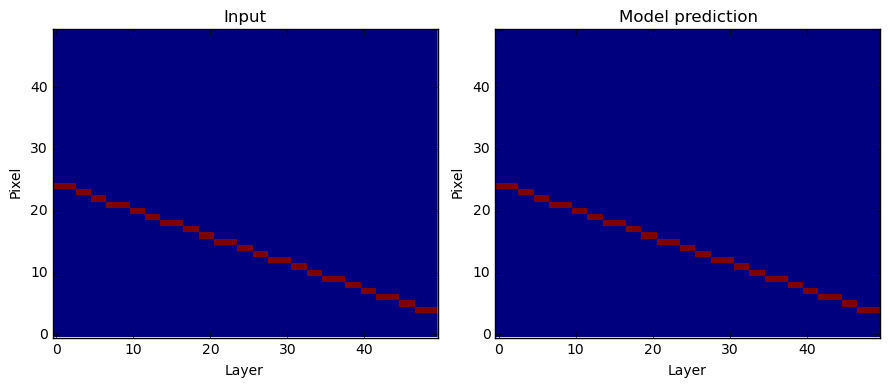

In [219]:
# Visualize prediction
events, targets = gen_tracks().next()
event = events[0]
x_target = targets[0][0]
y_target = targets[1][0]
pred = model_1.predict(np.asarray([event]))
x_pred = np.argmax( np.squeeze(pred[0][0]), axis=1 )
y_pred = np.argmax( np.squeeze(pred[1][0]), axis=1 )
xy_pred = np.array(zip(x_pred, y_pred))

pred_event = np.zeros((det_depth, det_width))
for x,y in xy_pred:
    pred_event[x,y] = 1
draw_input_and_pred(event[0], pred_event)

It seems to work as hoped.  For each output of the LSTM, the most probable pixel in the right-hand image is lighted up.  

The next step is to add multiple tracks, provide a seed (the track intercept) and see if the model picks the correct track out of the image.  

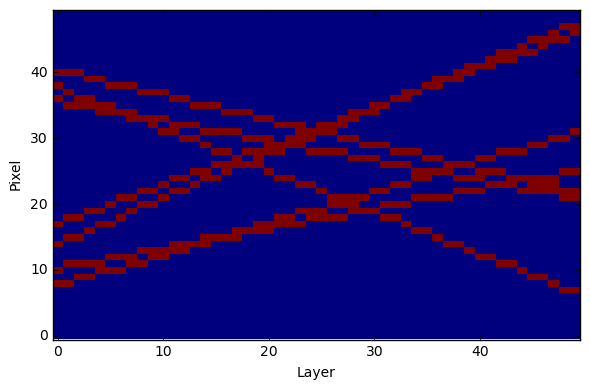

In [299]:
# Test the multi-track data generator
inputs, targets = gen_multi_tracks().next()
tracks, intercepts = inputs
draw_event(tracks[0,0])

In [294]:
# Model
def build_model_2():
    """Same as model 1, but with an extra input for the track seed"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    seed_input_layer = layers.Input(shape=(1,))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.merge([layer, seed_input_layer], mode='concat', concat_axis=1)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(det_depth)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    # Output a softmax over all pixels in the x- and y-directions
    output_layer_x = layers.TimeDistributed(layers.Dense(det_depth, activation='softmax'))(layer)
    output_layer_y = layers.TimeDistributed(layers.Dense(det_width, activation='softmax'))(layer)
    model = models.Model(input=[input_layer, seed_input_layer], output=[output_layer_x, output_layer_y])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', sample_weight_mode='temporal')
    return model

In [300]:
# Train the model
model_2 = build_model_2()
train_generator = gen_multi_tracks()
%time model_2.fit_generator(train_generator, epoch_size, 12)

Epoch 1/12
256000/256000 [==============================] - 235s - loss: 3.0442 - timedistributed_23_loss: 0.6906 - timedistributed_24_loss: 2.3536   
Epoch 2/12
256000/256000 [==============================] - 236s - loss: 1.9343 - timedistributed_23_loss: 0.1847 - timedistributed_24_loss: 1.7495   
Epoch 3/12
256000/256000 [==============================] - 236s - loss: 1.6137 - timedistributed_23_loss: 0.0982 - timedistributed_24_loss: 1.5155   
Epoch 4/12
256000/256000 [==============================] - 237s - loss: 1.4938 - timedistributed_23_loss: 0.1190 - timedistributed_24_loss: 1.3748   
Epoch 5/12
256000/256000 [==============================] - 236s - loss: 1.2858 - timedistributed_23_loss: 0.0618 - timedistributed_24_loss: 1.2240   
Epoch 6/12
256000/256000 [==============================] - 237s - loss: 1.1117 - timedistributed_23_loss: 0.0043 - timedistributed_24_loss: 1.1074   
Epoch 7/12
256000/256000 [==============================] - 236s - loss: 1.1789 - timedistribu

In [4]:
def draw_input_target_pred(event_input, event_target, event_pred, figsize=(9,4), mask_ranges=None):
    plt.figure(figsize=figsize)
    plt.subplot(131)
    draw_event(event_input, title='Input', mask_ranges=mask_ranges)
    plt.subplot(132)
    draw_event(event_target, title='Target', mask_ranges=mask_ranges)
    plt.subplot(133)
    draw_event(event_pred, title='Model prediction', mask_ranges=mask_ranges)

# Visualize prediction
def visualize_n(model):
    inputs, targets = gen_n_tracks().next()
    event = inputs[0][0]
    seed = inputs[1][0]
    x_target = targets[0][0]
    y_target = targets[1][0]
    pred = model.predict([np.array([event]), np.array([seed])])
    x_pred = np.argmax( np.squeeze(pred[0][0]), axis=1 )
    y_pred = np.argmax( np.squeeze(pred[1][0]), axis=1 )
    xy_pred = np.array(zip(x_pred, y_pred))
    pred_event = np.zeros((det_depth, det_width))
    for x,y in xy_pred:
        pred_event[x,y] = 1
    xy_target = np.array(zip(np.squeeze(x_target), np.squeeze(y_target))).astype(int)
    target_event = np.zeros((det_depth, det_width))
    for x,y in xy_target:
        target_event[x,y] = 1
    draw_input_target_pred(event[0], target_event, pred_event)

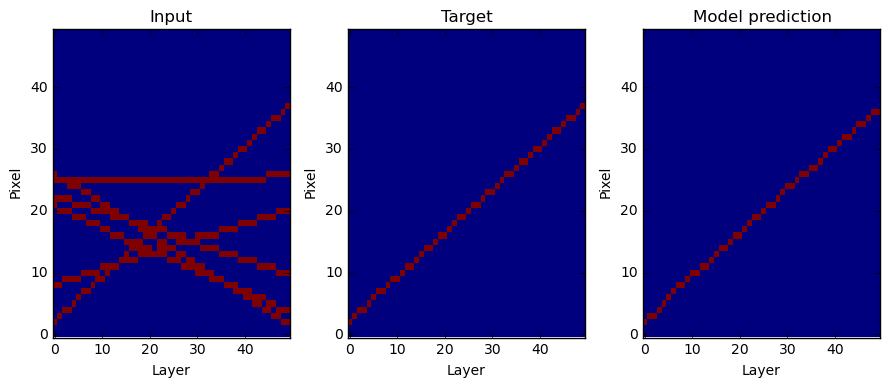

In [312]:
visualize_n(model_2)

The model usually selects the correct track and follows it.  However, it doesn't get the pixels exactly right.

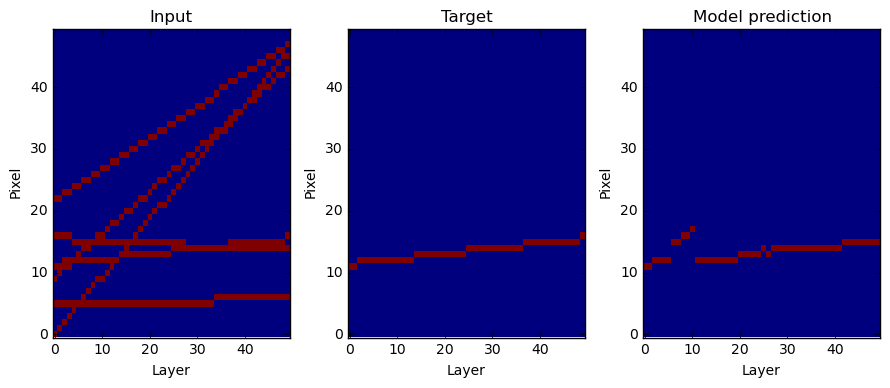

In [317]:
visualize_n(model_2)

When tracks cross, the model outputs become unreliable.  We could learn more by looking at the probabilities produced by the model, rather than just the most likely pixels.  

The biggest problem, though, is the fact that the model does not necessarily choose the right pixels for the track.  That makes it unsuitable for the recursive algorithm we discussed, in which the pixels indicated by the model are turned off at each iteration.  

Suggestion from Stephan: use regularization to encourage sequential model outputs to be close together.  To do that, we need to write a custom keras regularizer.

### Regularize using Kullback-Leibler divergence

In [20]:
reload(kl_regularizer)

<module 'kl_regularizer' from 'kl_regularizer.py'>

In [55]:
import kl_regularizer # local import

# Model
def build_model_3():
    """Same as model 2, but with regularization on the KL divergence"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    seed_input_layer = layers.Input(shape=(1,))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.merge([layer, seed_input_layer], mode='concat', concat_axis=1)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(det_depth)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    # Output a softmax over all pixels in the x- and y-directions
    layer_x = layers.TimeDistributed(layers.Dense(det_depth, activation='softmax'))(layer)
    layer_y = layers.TimeDistributed(layers.Dense(det_width, activation='softmax'))(layer)
    output_layer_x = kl_regularizer.KLRegularization(k=1e-4)(layer_x)
    output_layer_y = kl_regularizer.KLRegularization(k=1e-4)(layer_y)
    model = models.Model(input=[input_layer, seed_input_layer], output=[output_layer_x, output_layer_y])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', sample_weight_mode='temporal')
    return model

In [56]:
# Train the model
model_3 = build_model_3()
train_generator = gen_multi_tracks()
%time model_3.fit_generator(train_generator, epoch_size, 20)

Epoch 1/20
256000/256000 [==============================] - 245s - loss: 3.8104 - klregularization_17_loss: 1.1690 - klregularization_18_loss: 2.2386   
Epoch 2/20
256000/256000 [==============================] - 246s - loss: 3.0182 - klregularization_17_loss: 0.9088 - klregularization_18_loss: 1.5928   
Epoch 3/20
256000/256000 [==============================] - 255s - loss: 2.7924 - klregularization_17_loss: 0.8763 - klregularization_18_loss: 1.3661   
Epoch 4/20
256000/256000 [==============================] - 246s - loss: 2.6784 - klregularization_17_loss: 0.8777 - klregularization_18_loss: 1.2347   
Epoch 5/20
256000/256000 [==============================] - 259s - loss: 2.6600 - klregularization_17_loss: 0.9165 - klregularization_18_loss: 1.1826   
Epoch 6/20
256000/256000 [==============================] - 266s - loss: 2.6621 - klregularization_17_loss: 0.9386 - klregularization_18_loss: 1.1618   
Epoch 7/20
256000/256000 [==============================] - 256s - loss: 2.5775 - 

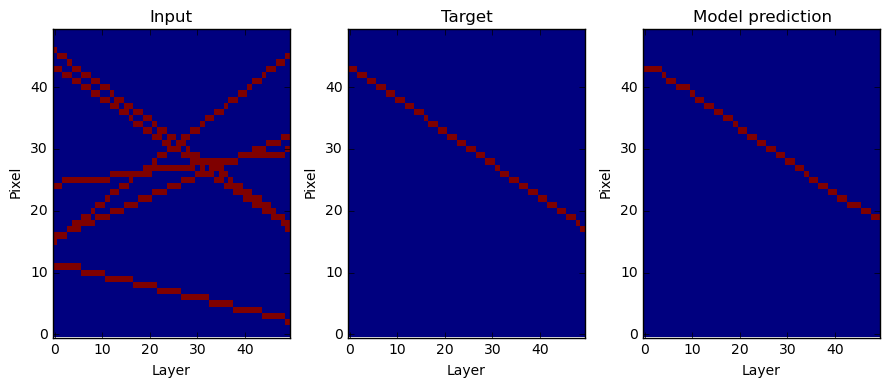

In [57]:
visualize_n(model_3)